In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import fasttext
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk


#######needed these ones on the first run####
#nltk.download('punkt') 
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('vader_lexicon')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer



from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')
%matplotlib inline
# import a lot of libraries that could be used on the project

In [2]:
# recipes = pd.read_csv('foodcom_with_reviews/recipes.csv')
reviews = pd.read_csv('foodcom_with_reviews/reviews.csv')

In [4]:
# recipes.head(1)

In [5]:
reviews.head(1)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z


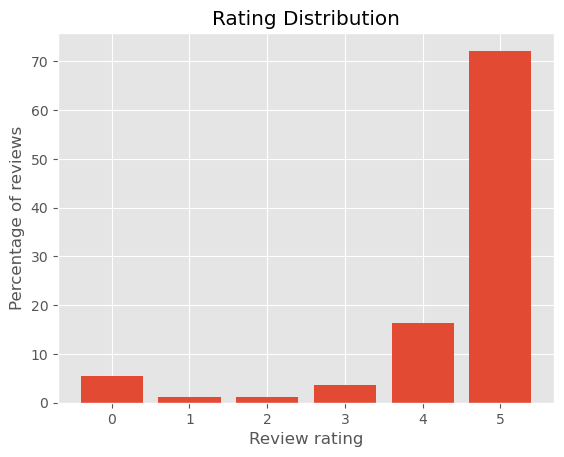

In [6]:
values, counts = np.unique(reviews['Rating'], return_counts = True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('Percentage of reviews')
plt.title('Rating Distribution')
plt.show()

In [7]:
reviews.shape

(1401982, 8)

In [8]:
# dropping reviews that are 3 or 4
reviews = reviews.drop(reviews[(reviews['Rating'] == 3) | (reviews['Rating'] == 4)].index)

I droped reviews that are 3 and 4 because I want to take only extremes to have a better training on if the word is positive or negative. 3 and 4 could be neutral or mixed review which could confuse my model.

In [9]:
reviews['Sentiment'] = np.where(reviews['Rating'] >=4, 1, 0) 
#later replace with reviews_simple or something like that
reviews.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z,1
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could taste the cornstarch in the finished product.,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z,0
3,13,7435,1773,Malarkey Test,5,"easily the best i have ever had. juicy flavorful, not dry. the vegetables retain crispness as ...",2000-03-13T21:15:00Z,2000-03-13T21:15:00Z,1


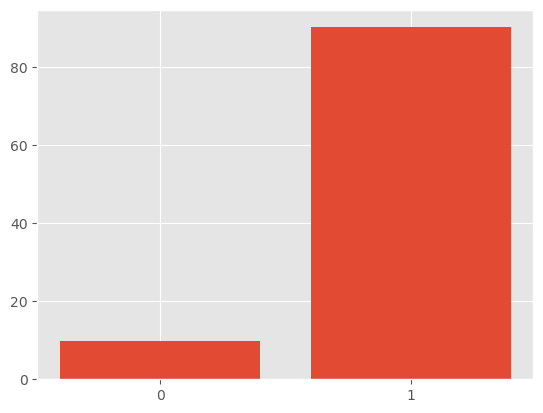

In [10]:
values, counts = np.unique(reviews['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(['0','1'], normalized_counts*100)
plt.show()

In [11]:
print(values)
print(counts)

[0 1]
[ 110404 1012082]


# Start to tokenize

In [12]:
def my_tokenizer(sentence):
    # Instantiate stemmer and stopwords from nltk
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Making them lower case and remove punctuation
    stemmed_words = [stemmer.stem(word.lower()) for word in words if word.isalpha()]

    # Remove if it is a stop words
    filtered_words = [word for word in stemmed_words if word not in stop_words]

    return filtered_words

In [13]:
# checking my tokenizer
example_sentence = "The quick brown fox, jumped over the lazy dog!!"
my_tokenizer(example_sentence)

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog']

In [14]:
# reviews['Tokenized_Reviews'] = reviews['Review'].apply(my_tokenizer)
# reviews.head(2)

In [15]:
# Convert the values in the 'Review' column to strings
reviews['Review'] = reviews['Review'].astype(str)


# Sample a subset of the data
sample_reviews = reviews.sample(n=50000, random_state=1)


# Apply the tokenizer function to the sampled reviews
tokenized_reviews = sample_reviews['Review'].apply(my_tokenizer)

sample_reviews['Tokenized_Reviews'] = tokenized_reviews
sample_reviews['Tokenized_Reviews'].head(3)

1378824                                                                               [made, yesterday, great]
1328352    [love, pea, soup, laid, bad, cold, sinu, go, tackl, make, thi, soup, worri, miss, meal, better, ...
1054228                       [thi, great, recip, wa, milk, substitut, sour, cream, stead, milk, made, awesom]
Name: Tokenized_Reviews, dtype: object

In [16]:
# # Separate the data into features (X) and target (y)
# X = reviews.drop('Sentiment', axis=1)
# y = reviews['Sentiment']

# # Taking a chunk for our 20% test set
# X_remainder, X_test, y_remainder, y_test = \
#     train_test_split(X, y, stratify=y, test_size = 0.2,
#                      random_state=1)



In [17]:
# # Splitting the remainder in two chunks
# X_train, X_validation, y_train, y_validation = \
#     train_test_split(X_remainder, y_remainder, test_size = 0.3,
#                      random_state=1)


In [18]:
# X_test.shape #just checking the shape

In [19]:
# X_train.shape

In [20]:


X_sample = sample_reviews['Tokenized_Reviews'].astype(str)
y_sample = sample_reviews['Sentiment']

# Perform stratified sampling to obtain a balanced sample
X_remainder_sample, X_test_sample, y_remainder_sample, y_test_sample = train_test_split(X_sample, y_sample,  test_size=0.2, stratify=y_sample, random_state=1)

# Splitting the remainder in two chunks
X_train_sample, X_validation_sample, y_train_sample, y_validation_sample = \
    train_test_split(X_remainder_sample, y_remainder_sample, test_size = 0.3,
                     random_state=1)
    

In [21]:
X_train_sample.shape

(28000,)

In [22]:
X_test_sample.shape

(10000,)

In [23]:
# Combine the features and target back into a DataFrame
sampled_reviews = pd.concat([X_remainder_sample, y_remainder_sample], axis=1)
sampled_reviews.head(3)

,Tokenized_Reviews,Sentiment
380270,"['great', 'recip', 'requir', 'cook']",1
323111,"['tri', 'thi', 'recip', 'sunday', 'night', 'follow', 'recip', 'exactli', 'wow', 'great', 'tast',...",1
807230,"['thi', 'delici', 'dish', 'even', 'non', 'veggi', 'eat', 'dh', 'realli', 'realli', 'like', 'ad',...",1


In [24]:
X_train_sample.head(3)

976281     ['love', 'aroma', 'thi', 'steak', 'pan', 'fri', 'could', 'wait', 'take', 'bite', 'squeez', 'piec...
1364926    ['thi', 'wa', 'veri', 'veri', 'tasti', 'onli', 'chang', 'made', 'wa', 'add', 'cream', 'mushroom'...
945691     ['made', 'thi', 'husband', 'birthday', 'follow', 'recip', 'exactli', 'wa', 'wonder', 'cake', 'mo...
Name: Tokenized_Reviews, dtype: object

In [25]:
X_test_sample.head(3)

599071     ['yummi', 'lot', 'compliment', 'thi', 'one', 'easi', 'make', 'doe', 'take', 'ton', 'time', 'ton'...
1052733    ['veri', 'good', 'make', 'thi', 'onli', 'thing', 'differ', 'wa', 'add', 'garlic', 'thank', 'shar...
680381                                                     ['sweet', 'weird', 'flavor', 'sure', 'got', 'star']
Name: Tokenized_Reviews, dtype: object

In [26]:
sampled_reviews['Sentiment'].value_counts()
# imbalance on the values

1    36026
0     3974
Name: Sentiment, dtype: int64

In [49]:
# from imblearn.over_sampling import RandomOverSampler
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=1)

# X_train_sample = X_train_sample.to_numpy().reshape(-1, 1)
# y_train_sample = y_train_sample.to_numpy().reshape(-1, 1)

# X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_sample, y_train_sample)


In [50]:
# # Convert oversampled data to DataFrames
# X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=['Review'])
# y_train_oversampled = pd.DataFrame(y_train_oversampled, columns=['Sentiment'])

# # Combine the features and target back into a DataFrame
# oversampled_reviews = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)
# oversampled_reviews.head(3)

,Review,Sentiment
0,"['love', 'aroma', 'thi', 'steak', 'pan', 'fri', 'could', 'wait', 'take', 'bite', 'squeez', 'piec...",1
1,"['thi', 'wa', 'veri', 'veri', 'tasti', 'onli', 'chang', 'made', 'wa', 'add', 'cream', 'mushroom'...",1
2,"['made', 'thi', 'husband', 'birthday', 'follow', 'recip', 'exactli', 'wa', 'wonder', 'cake', 'mo...",1


In [51]:
# oversampled_reviews['Sentiment'].value_counts()

1    25182
0    25182
Name: Sentiment, dtype: int64

This is a lot more balanced!

In [30]:
# type(X_train_oversampled)

In [31]:
# type(X_train_sample)

In [32]:
# X_train_sample, y_train_sample = oversampler.fit_resample(X_train_sample, y_train_sample)

In [33]:
# type(X_train_sample)

In [34]:
# # Convert oversampled data to DataFrames
# X_train_sample = pd.DataFrame(X_train_sample, columns=['Review'])
# y_train_sample = pd.DataFrame(y_train_sample, columns=['Sentiment'])

# # Combine the features and target back into a DataFrame
# sampled_reviews = pd.concat([X_train_sample, y_train_sample], axis=1)
# sampled_reviews.head(3)

In [35]:
# sampled_reviews['Sentiment'].value_counts()

In [36]:
# print(X_train_sample.dtypes)
# print(y_train_sample.dtypes)

In [37]:
# type(X_train) #I was having problem with the type for some reason
# # solved it by using '.astype(str)'

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with your tokenizer function
bagofwords = CountVectorizer(min_df=5, max_df=0.8)

# Fit and transform the training data
X_train_sample_transformed = bagofwords.fit_transform(X_train_sample)

# Transform the test data using the fitted CountVectorizer
X_test_sample_transformed = bagofwords.transform(X_test_sample)

# Check the shape of the transformed data
print(X_train_sample_transformed.shape)
print(X_test_sample_transformed.shape)

(28000, 4560)
(10000, 4560)


In [39]:
bagofwords.get_feature_names_out()

array(['abc', 'abit', 'abl', ..., 'zuchinni', 'zuke', 'zwt'], dtype=object)

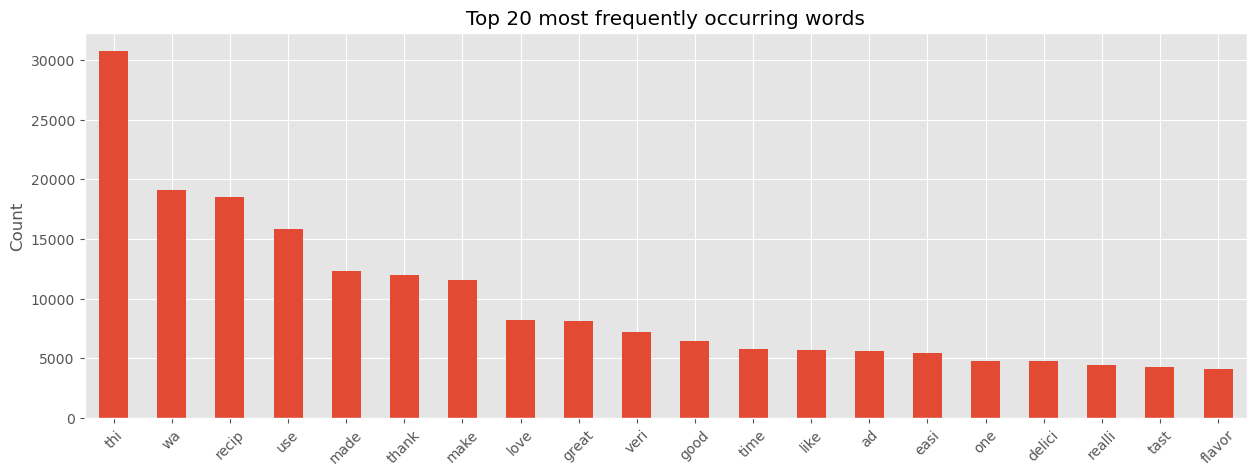

In [40]:
word_counts = pd.DataFrame(
    {"counts": X_train_sample_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [41]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_sample_transformed, y_train_sample)

# Training and test score
print(f"Train score: {logreg.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {logreg.score(X_test_sample_transformed, y_test_sample)}")

Train score: 0.9288928571428572
Test score: 0.9189


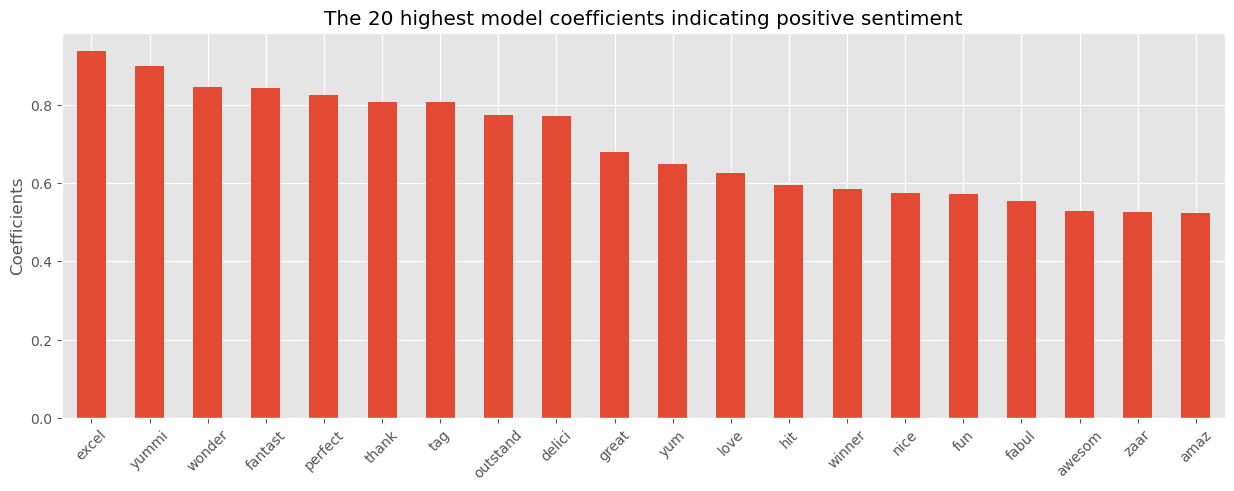

In [42]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

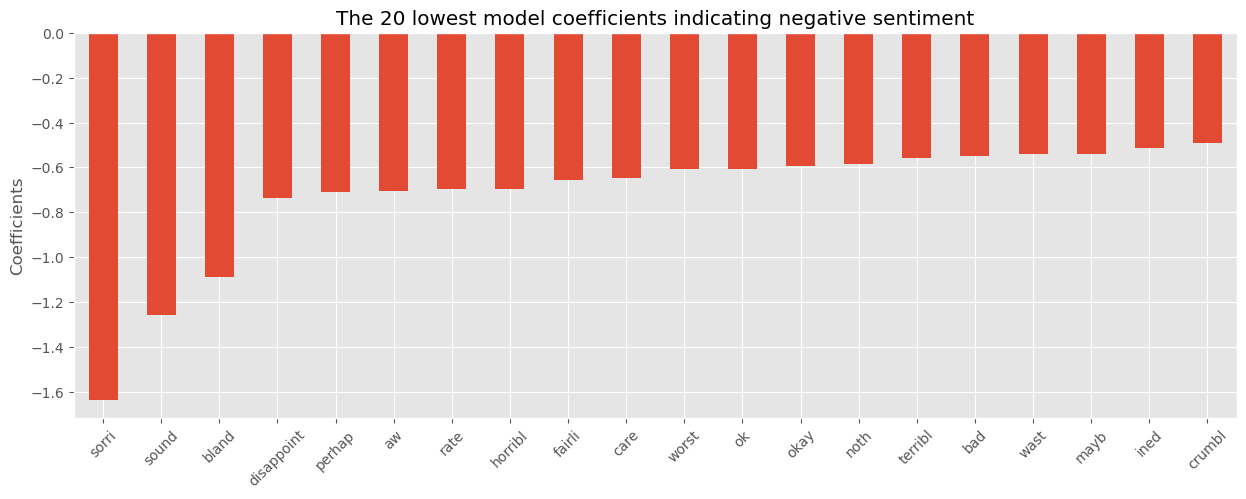

In [43]:
word_counts.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [44]:
# Preprocess the new sentence
new_sentence = "I hate this, its a disapointment, its bland sorry"
new_sentece = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
#preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string
# preprocessed not really working, have to update this
preprocessed_sentence

#check recall , balance, confusion matrix, TIDF ---> different type (score based on how often they appear)
# check decision tree, knn, compre different models


['hate', 'thi', 'disapoint', 'bland', 'sorri']

In [45]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
new_sentence_transformed = bagofwords.transform([preprocessed_sentence[0]])

print(logreg.predict(new_sentence_transformed))

[1]


In [46]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
new_sentence_transformed = bagofwords.transform([preprocessed_sentence[0]])


# Make a prediction on the transformed sentence using the trained logistic regression model
sentiment_prediction = logreg.predict(new_sentence_transformed)

# Interpret the prediction ... 1 would be something similar to a good rating (4 or 5 stars), while 0 would be a bad one
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")

The sentence has a positive sentiment.


In [47]:
# questions to make
# should i make a decision tree for the recomendation? or knn or something with bayes?

# self note: do model evaluation, test True positives, false positive, true negative, false negative
# there is class imbalance so do model evaluation stuff
# i hae to do a value_counts to see how many i have of each rating to make a good resample
# use stratify , will pick samples in a smart way

In [48]:
# acurracy , precision, recall, confusion matrix
# ok i have to try different classifiers, hyperparameters (diffeerent c values, k values, which ones are performing the best)
# resample
# stratify
# create similar content to the text adata, how do we write code, expand on my own data.
# word cloud is ok


In [ ]:
# try svm, hyper parameter, KNN, create pipelines ----> 
# ue counvectorizer or tfid... check ML pipelines.... 